# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


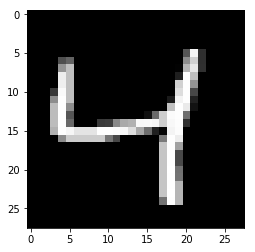

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [7]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name="inputs")
targets_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name="targets")

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=16, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2, 2), strides=(2, 2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=8, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2, 2), strides=(2, 2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=8, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(inputs=conv3, pool_size=(2, 2), strides=(2, 2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(images=encoded, size=(7, 7))
# Now 7x7x8
conv4 = tf.layers.conv2d(inputs=upsample1, filters=8, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(images=conv4, size=(14, 14))
# Now 14x14x8
conv5 = tf.layers.conv2d(inputs=upsample2, filters=8, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(images=conv5, size=(28, 28))
# Now 28x28x8
conv6 = tf.layers.conv2d(inputs=upsample3, filters=16, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3, 3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name="outputs")

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [17]:
sess = tf.Session()

In [18]:
epochs = 10
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10... Training loss: 0.6945
Epoch: 1/10... Training loss: 0.6930
Epoch: 1/10... Training loss: 0.6917
Epoch: 1/10... Training loss: 0.6907
Epoch: 1/10... Training loss: 0.6896
Epoch: 1/10... Training loss: 0.6883
Epoch: 1/10... Training loss: 0.6869
Epoch: 1/10... Training loss: 0.6853
Epoch: 1/10... Training loss: 0.6836
Epoch: 1/10... Training loss: 0.6815
Epoch: 1/10... Training loss: 0.6790
Epoch: 1/10... Training loss: 0.6766
Epoch: 1/10... Training loss: 0.6736
Epoch: 1/10... Training loss: 0.6699
Epoch: 1/10... Training loss: 0.6656
Epoch: 1/10... Training loss: 0.6611
Epoch: 1/10... Training loss: 0.6552
Epoch: 1/10... Training loss: 0.6482
Epoch: 1/10... Training loss: 0.6407
Epoch: 1/10... Training loss: 0.6318
Epoch: 1/10... Training loss: 0.6201
Epoch: 1/10... Training loss: 0.6073
Epoch: 1/10... Training loss: 0.5934
Epoch: 1/10... Training loss: 0.5758
Epoch: 1/10... Training loss: 0.5622
Epoch: 1/10... Training loss: 0.5433
Epoch: 1/10... Training loss: 0.5238
E

Epoch: 1/10... Training loss: 0.1512
Epoch: 1/10... Training loss: 0.1515
Epoch: 1/10... Training loss: 0.1501
Epoch: 1/10... Training loss: 0.1529
Epoch: 1/10... Training loss: 0.1497
Epoch: 1/10... Training loss: 0.1482
Epoch: 1/10... Training loss: 0.1506
Epoch: 1/10... Training loss: 0.1537
Epoch: 1/10... Training loss: 0.1501
Epoch: 1/10... Training loss: 0.1538
Epoch: 1/10... Training loss: 0.1520
Epoch: 1/10... Training loss: 0.1487
Epoch: 1/10... Training loss: 0.1506
Epoch: 1/10... Training loss: 0.1524
Epoch: 1/10... Training loss: 0.1549
Epoch: 1/10... Training loss: 0.1488
Epoch: 1/10... Training loss: 0.1445
Epoch: 1/10... Training loss: 0.1508
Epoch: 1/10... Training loss: 0.1498
Epoch: 1/10... Training loss: 0.1453
Epoch: 1/10... Training loss: 0.1516
Epoch: 1/10... Training loss: 0.1519
Epoch: 1/10... Training loss: 0.1446
Epoch: 1/10... Training loss: 0.1480
Epoch: 1/10... Training loss: 0.1508
Epoch: 1/10... Training loss: 0.1482
Epoch: 1/10... Training loss: 0.1423
E

Epoch: 2/10... Training loss: 0.1320
Epoch: 2/10... Training loss: 0.1367
Epoch: 2/10... Training loss: 0.1305
Epoch: 2/10... Training loss: 0.1353
Epoch: 2/10... Training loss: 0.1345
Epoch: 2/10... Training loss: 0.1284
Epoch: 2/10... Training loss: 0.1278
Epoch: 2/10... Training loss: 0.1390
Epoch: 2/10... Training loss: 0.1334
Epoch: 2/10... Training loss: 0.1355
Epoch: 2/10... Training loss: 0.1313
Epoch: 2/10... Training loss: 0.1329
Epoch: 2/10... Training loss: 0.1322
Epoch: 2/10... Training loss: 0.1289
Epoch: 2/10... Training loss: 0.1354
Epoch: 2/10... Training loss: 0.1361
Epoch: 2/10... Training loss: 0.1320
Epoch: 2/10... Training loss: 0.1330
Epoch: 2/10... Training loss: 0.1345
Epoch: 2/10... Training loss: 0.1343
Epoch: 2/10... Training loss: 0.1328
Epoch: 2/10... Training loss: 0.1285
Epoch: 2/10... Training loss: 0.1270
Epoch: 2/10... Training loss: 0.1312
Epoch: 2/10... Training loss: 0.1353
Epoch: 2/10... Training loss: 0.1297
Epoch: 2/10... Training loss: 0.1330
E

Epoch: 3/10... Training loss: 0.1244
Epoch: 3/10... Training loss: 0.1230
Epoch: 3/10... Training loss: 0.1273
Epoch: 3/10... Training loss: 0.1280
Epoch: 3/10... Training loss: 0.1293
Epoch: 3/10... Training loss: 0.1260
Epoch: 3/10... Training loss: 0.1262
Epoch: 3/10... Training loss: 0.1248
Epoch: 3/10... Training loss: 0.1301
Epoch: 3/10... Training loss: 0.1240
Epoch: 3/10... Training loss: 0.1282
Epoch: 3/10... Training loss: 0.1243
Epoch: 3/10... Training loss: 0.1267
Epoch: 3/10... Training loss: 0.1243
Epoch: 3/10... Training loss: 0.1220
Epoch: 3/10... Training loss: 0.1256
Epoch: 3/10... Training loss: 0.1243
Epoch: 3/10... Training loss: 0.1286
Epoch: 3/10... Training loss: 0.1233
Epoch: 3/10... Training loss: 0.1245
Epoch: 3/10... Training loss: 0.1317
Epoch: 3/10... Training loss: 0.1259
Epoch: 3/10... Training loss: 0.1231
Epoch: 3/10... Training loss: 0.1224
Epoch: 3/10... Training loss: 0.1217
Epoch: 3/10... Training loss: 0.1229
Epoch: 3/10... Training loss: 0.1217
E

Epoch: 3/10... Training loss: 0.1209
Epoch: 3/10... Training loss: 0.1179
Epoch: 3/10... Training loss: 0.1189
Epoch: 3/10... Training loss: 0.1213
Epoch: 3/10... Training loss: 0.1221
Epoch: 3/10... Training loss: 0.1189
Epoch: 3/10... Training loss: 0.1208
Epoch: 3/10... Training loss: 0.1180
Epoch: 3/10... Training loss: 0.1190
Epoch: 3/10... Training loss: 0.1253
Epoch: 3/10... Training loss: 0.1212
Epoch: 3/10... Training loss: 0.1232
Epoch: 4/10... Training loss: 0.1234
Epoch: 4/10... Training loss: 0.1191
Epoch: 4/10... Training loss: 0.1168
Epoch: 4/10... Training loss: 0.1183
Epoch: 4/10... Training loss: 0.1202
Epoch: 4/10... Training loss: 0.1171
Epoch: 4/10... Training loss: 0.1185
Epoch: 4/10... Training loss: 0.1246
Epoch: 4/10... Training loss: 0.1207
Epoch: 4/10... Training loss: 0.1222
Epoch: 4/10... Training loss: 0.1204
Epoch: 4/10... Training loss: 0.1151
Epoch: 4/10... Training loss: 0.1229
Epoch: 4/10... Training loss: 0.1210
Epoch: 4/10... Training loss: 0.1223
E

Epoch: 4/10... Training loss: 0.1174
Epoch: 4/10... Training loss: 0.1175
Epoch: 4/10... Training loss: 0.1197
Epoch: 4/10... Training loss: 0.1193
Epoch: 4/10... Training loss: 0.1199
Epoch: 4/10... Training loss: 0.1100
Epoch: 4/10... Training loss: 0.1247
Epoch: 4/10... Training loss: 0.1171
Epoch: 4/10... Training loss: 0.1153
Epoch: 4/10... Training loss: 0.1179
Epoch: 4/10... Training loss: 0.1160
Epoch: 4/10... Training loss: 0.1168
Epoch: 4/10... Training loss: 0.1152
Epoch: 4/10... Training loss: 0.1171
Epoch: 4/10... Training loss: 0.1188
Epoch: 4/10... Training loss: 0.1188
Epoch: 4/10... Training loss: 0.1132
Epoch: 4/10... Training loss: 0.1160
Epoch: 4/10... Training loss: 0.1156
Epoch: 4/10... Training loss: 0.1127
Epoch: 4/10... Training loss: 0.1175
Epoch: 4/10... Training loss: 0.1172
Epoch: 4/10... Training loss: 0.1182
Epoch: 4/10... Training loss: 0.1152
Epoch: 4/10... Training loss: 0.1153
Epoch: 4/10... Training loss: 0.1196
Epoch: 4/10... Training loss: 0.1209
E

Epoch: 5/10... Training loss: 0.1172
Epoch: 5/10... Training loss: 0.1168
Epoch: 5/10... Training loss: 0.1127
Epoch: 5/10... Training loss: 0.1158
Epoch: 5/10... Training loss: 0.1165
Epoch: 5/10... Training loss: 0.1112
Epoch: 5/10... Training loss: 0.1124
Epoch: 5/10... Training loss: 0.1167
Epoch: 5/10... Training loss: 0.1167
Epoch: 5/10... Training loss: 0.1167
Epoch: 5/10... Training loss: 0.1144
Epoch: 5/10... Training loss: 0.1103
Epoch: 5/10... Training loss: 0.1157
Epoch: 5/10... Training loss: 0.1150
Epoch: 5/10... Training loss: 0.1124
Epoch: 5/10... Training loss: 0.1134
Epoch: 5/10... Training loss: 0.1123
Epoch: 5/10... Training loss: 0.1161
Epoch: 5/10... Training loss: 0.1157
Epoch: 5/10... Training loss: 0.1149
Epoch: 5/10... Training loss: 0.1153
Epoch: 5/10... Training loss: 0.1181
Epoch: 5/10... Training loss: 0.1142
Epoch: 5/10... Training loss: 0.1121
Epoch: 5/10... Training loss: 0.1118
Epoch: 5/10... Training loss: 0.1150
Epoch: 5/10... Training loss: 0.1104
E

Epoch: 6/10... Training loss: 0.1108
Epoch: 6/10... Training loss: 0.1130
Epoch: 6/10... Training loss: 0.1141
Epoch: 6/10... Training loss: 0.1109
Epoch: 6/10... Training loss: 0.1131
Epoch: 6/10... Training loss: 0.1116
Epoch: 6/10... Training loss: 0.1127
Epoch: 6/10... Training loss: 0.1071
Epoch: 6/10... Training loss: 0.1165
Epoch: 6/10... Training loss: 0.1103
Epoch: 6/10... Training loss: 0.1133
Epoch: 6/10... Training loss: 0.1122
Epoch: 6/10... Training loss: 0.1101
Epoch: 6/10... Training loss: 0.1102
Epoch: 6/10... Training loss: 0.1161
Epoch: 6/10... Training loss: 0.1126
Epoch: 6/10... Training loss: 0.1057
Epoch: 6/10... Training loss: 0.1134
Epoch: 6/10... Training loss: 0.1128
Epoch: 6/10... Training loss: 0.1145
Epoch: 6/10... Training loss: 0.1125
Epoch: 6/10... Training loss: 0.1140
Epoch: 6/10... Training loss: 0.1086
Epoch: 6/10... Training loss: 0.1080
Epoch: 6/10... Training loss: 0.1095
Epoch: 6/10... Training loss: 0.1101
Epoch: 6/10... Training loss: 0.1102
E

Epoch: 6/10... Training loss: 0.1103
Epoch: 6/10... Training loss: 0.1053
Epoch: 6/10... Training loss: 0.1100
Epoch: 6/10... Training loss: 0.1105
Epoch: 6/10... Training loss: 0.1138
Epoch: 6/10... Training loss: 0.1112
Epoch: 6/10... Training loss: 0.1084
Epoch: 6/10... Training loss: 0.1087
Epoch: 6/10... Training loss: 0.1095
Epoch: 6/10... Training loss: 0.1106
Epoch: 6/10... Training loss: 0.1132
Epoch: 6/10... Training loss: 0.1092
Epoch: 6/10... Training loss: 0.1107
Epoch: 6/10... Training loss: 0.1124
Epoch: 6/10... Training loss: 0.1113
Epoch: 6/10... Training loss: 0.1111
Epoch: 6/10... Training loss: 0.1083
Epoch: 6/10... Training loss: 0.1093
Epoch: 6/10... Training loss: 0.1070
Epoch: 6/10... Training loss: 0.1117
Epoch: 6/10... Training loss: 0.1064
Epoch: 6/10... Training loss: 0.1129
Epoch: 6/10... Training loss: 0.1115
Epoch: 6/10... Training loss: 0.1096
Epoch: 7/10... Training loss: 0.1097
Epoch: 7/10... Training loss: 0.1113
Epoch: 7/10... Training loss: 0.1091
E

Epoch: 7/10... Training loss: 0.1118
Epoch: 7/10... Training loss: 0.1075
Epoch: 7/10... Training loss: 0.1084
Epoch: 7/10... Training loss: 0.1121
Epoch: 7/10... Training loss: 0.1068
Epoch: 7/10... Training loss: 0.1071
Epoch: 7/10... Training loss: 0.1057
Epoch: 7/10... Training loss: 0.1078
Epoch: 7/10... Training loss: 0.1056
Epoch: 7/10... Training loss: 0.1062
Epoch: 7/10... Training loss: 0.1125
Epoch: 7/10... Training loss: 0.1122
Epoch: 7/10... Training loss: 0.1054
Epoch: 7/10... Training loss: 0.1080
Epoch: 7/10... Training loss: 0.1067
Epoch: 7/10... Training loss: 0.1079
Epoch: 7/10... Training loss: 0.1030
Epoch: 7/10... Training loss: 0.1044
Epoch: 7/10... Training loss: 0.1077
Epoch: 7/10... Training loss: 0.1042
Epoch: 7/10... Training loss: 0.1079
Epoch: 7/10... Training loss: 0.1089
Epoch: 7/10... Training loss: 0.1067
Epoch: 7/10... Training loss: 0.1113
Epoch: 7/10... Training loss: 0.1113
Epoch: 7/10... Training loss: 0.1090
Epoch: 7/10... Training loss: 0.1108
E

Epoch: 8/10... Training loss: 0.1029
Epoch: 8/10... Training loss: 0.1073
Epoch: 8/10... Training loss: 0.1079
Epoch: 8/10... Training loss: 0.1048
Epoch: 8/10... Training loss: 0.1042
Epoch: 8/10... Training loss: 0.1093
Epoch: 8/10... Training loss: 0.1126
Epoch: 8/10... Training loss: 0.1069
Epoch: 8/10... Training loss: 0.1077
Epoch: 8/10... Training loss: 0.1098
Epoch: 8/10... Training loss: 0.1076
Epoch: 8/10... Training loss: 0.1116
Epoch: 8/10... Training loss: 0.1089
Epoch: 8/10... Training loss: 0.1052
Epoch: 8/10... Training loss: 0.1136
Epoch: 8/10... Training loss: 0.1050
Epoch: 8/10... Training loss: 0.1047
Epoch: 8/10... Training loss: 0.1123
Epoch: 8/10... Training loss: 0.1082
Epoch: 8/10... Training loss: 0.1096
Epoch: 8/10... Training loss: 0.1077
Epoch: 8/10... Training loss: 0.1090
Epoch: 8/10... Training loss: 0.1048
Epoch: 8/10... Training loss: 0.1076
Epoch: 8/10... Training loss: 0.1040
Epoch: 8/10... Training loss: 0.1066
Epoch: 8/10... Training loss: 0.1086
E

Epoch: 9/10... Training loss: 0.1062
Epoch: 9/10... Training loss: 0.1089
Epoch: 9/10... Training loss: 0.1081
Epoch: 9/10... Training loss: 0.1061
Epoch: 9/10... Training loss: 0.1053
Epoch: 9/10... Training loss: 0.1107
Epoch: 9/10... Training loss: 0.1068
Epoch: 9/10... Training loss: 0.1070
Epoch: 9/10... Training loss: 0.1091
Epoch: 9/10... Training loss: 0.1053
Epoch: 9/10... Training loss: 0.1048
Epoch: 9/10... Training loss: 0.1066
Epoch: 9/10... Training loss: 0.1081
Epoch: 9/10... Training loss: 0.1054
Epoch: 9/10... Training loss: 0.1052
Epoch: 9/10... Training loss: 0.1042
Epoch: 9/10... Training loss: 0.1061
Epoch: 9/10... Training loss: 0.1062
Epoch: 9/10... Training loss: 0.1021
Epoch: 9/10... Training loss: 0.1019
Epoch: 9/10... Training loss: 0.1138
Epoch: 9/10... Training loss: 0.1058
Epoch: 9/10... Training loss: 0.1072
Epoch: 9/10... Training loss: 0.1095
Epoch: 9/10... Training loss: 0.1082
Epoch: 9/10... Training loss: 0.1055
Epoch: 9/10... Training loss: 0.1066
E

Epoch: 9/10... Training loss: 0.1063
Epoch: 9/10... Training loss: 0.1078
Epoch: 9/10... Training loss: 0.1058
Epoch: 9/10... Training loss: 0.1064
Epoch: 9/10... Training loss: 0.1039
Epoch: 9/10... Training loss: 0.1038
Epoch: 9/10... Training loss: 0.1027
Epoch: 9/10... Training loss: 0.1074
Epoch: 9/10... Training loss: 0.1055
Epoch: 9/10... Training loss: 0.1008
Epoch: 9/10... Training loss: 0.1078
Epoch: 9/10... Training loss: 0.1023
Epoch: 9/10... Training loss: 0.1103
Epoch: 9/10... Training loss: 0.1087
Epoch: 9/10... Training loss: 0.1080
Epoch: 9/10... Training loss: 0.1072
Epoch: 9/10... Training loss: 0.1025
Epoch: 9/10... Training loss: 0.1069
Epoch: 9/10... Training loss: 0.1066
Epoch: 9/10... Training loss: 0.1074
Epoch: 9/10... Training loss: 0.1026
Epoch: 9/10... Training loss: 0.1061
Epoch: 9/10... Training loss: 0.1036
Epoch: 9/10... Training loss: 0.1049
Epoch: 9/10... Training loss: 0.1054
Epoch: 9/10... Training loss: 0.1019
Epoch: 9/10... Training loss: 0.1037
E

Epoch: 10/10... Training loss: 0.1075
Epoch: 10/10... Training loss: 0.1031
Epoch: 10/10... Training loss: 0.1028
Epoch: 10/10... Training loss: 0.1067
Epoch: 10/10... Training loss: 0.1052
Epoch: 10/10... Training loss: 0.1087
Epoch: 10/10... Training loss: 0.1054
Epoch: 10/10... Training loss: 0.1049
Epoch: 10/10... Training loss: 0.1076
Epoch: 10/10... Training loss: 0.1076
Epoch: 10/10... Training loss: 0.1049
Epoch: 10/10... Training loss: 0.1054
Epoch: 10/10... Training loss: 0.1048
Epoch: 10/10... Training loss: 0.1035
Epoch: 10/10... Training loss: 0.1052
Epoch: 10/10... Training loss: 0.1052
Epoch: 10/10... Training loss: 0.1045
Epoch: 10/10... Training loss: 0.1037
Epoch: 10/10... Training loss: 0.1029
Epoch: 10/10... Training loss: 0.1046
Epoch: 10/10... Training loss: 0.1019
Epoch: 10/10... Training loss: 0.1090
Epoch: 10/10... Training loss: 0.1054
Epoch: 10/10... Training loss: 0.1077
Epoch: 10/10... Training loss: 0.1031
Epoch: 10/10... Training loss: 0.1014
Epoch: 10/10

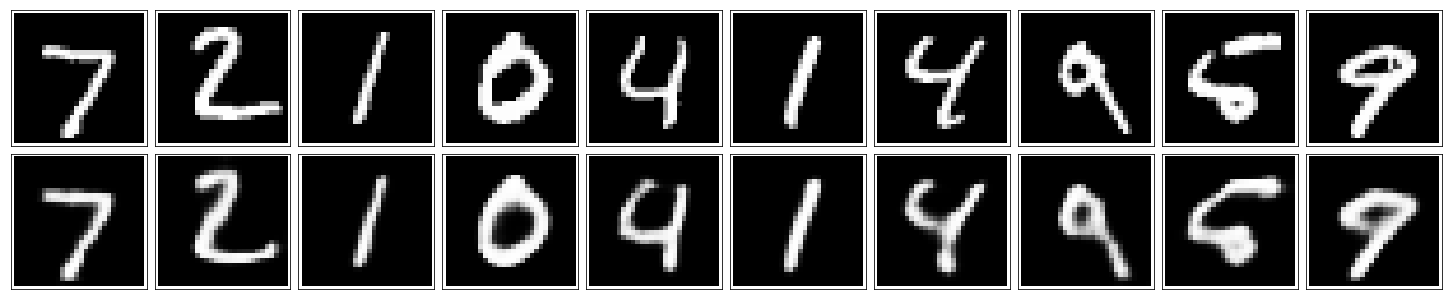

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [20]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [24]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2, 2), strides=(2, 2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2, 2), strides=(2, 2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=16, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(inputs=conv3, pool_size=(2, 2), strides=(2, 2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(images=encoded, size=(7, 7))
# Now 7x7x16
conv4 = tf.layers.conv2d(inputs=upsample1, filters=16, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(images=conv4, size=(14, 14))
# Now 14x14x16
conv5 = tf.layers.conv2d(inputs=upsample2, filters=32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(images=conv5, size=(28, 28))
# Now 28x28x32
conv6 = tf.layers.conv2d(inputs=upsample3, filters=32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3, 3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name="outputs")

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [25]:
sess = tf.Session()

In [27]:
epochs = 10
batch_size = 500
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10... Training loss: 0.6950
Epoch: 1/10... Training loss: 0.6857
Epoch: 1/10... Training loss: 0.6757
Epoch: 1/10... Training loss: 0.6588
Epoch: 1/10... Training loss: 0.6343
Epoch: 1/10... Training loss: 0.6012
Epoch: 1/10... Training loss: 0.5612
Epoch: 1/10... Training loss: 0.5181
Epoch: 1/10... Training loss: 0.4880
Epoch: 1/10... Training loss: 0.5018
Epoch: 1/10... Training loss: 0.5158
Epoch: 1/10... Training loss: 0.5075
Epoch: 1/10... Training loss: 0.4749
Epoch: 1/10... Training loss: 0.4713
Epoch: 1/10... Training loss: 0.4490
Epoch: 1/10... Training loss: 0.4438
Epoch: 1/10... Training loss: 0.4390
Epoch: 1/10... Training loss: 0.4349
Epoch: 1/10... Training loss: 0.4221
Epoch: 1/10... Training loss: 0.4138
Epoch: 1/10... Training loss: 0.4031
Epoch: 1/10... Training loss: 0.3896
Epoch: 1/10... Training loss: 0.3883
Epoch: 1/10... Training loss: 0.3673
Epoch: 1/10... Training loss: 0.3591
Epoch: 1/10... Training loss: 0.3513
Epoch: 1/10... Training loss: 0.3309
E

Epoch: 2/10... Training loss: 0.1761
Epoch: 2/10... Training loss: 0.1729
Epoch: 2/10... Training loss: 0.1731
Epoch: 2/10... Training loss: 0.1749
Epoch: 2/10... Training loss: 0.1722
Epoch: 2/10... Training loss: 0.1740
Epoch: 2/10... Training loss: 0.1746
Epoch: 2/10... Training loss: 0.1715
Epoch: 2/10... Training loss: 0.1727
Epoch: 2/10... Training loss: 0.1722
Epoch: 2/10... Training loss: 0.1745
Epoch: 2/10... Training loss: 0.1709
Epoch: 2/10... Training loss: 0.1715
Epoch: 2/10... Training loss: 0.1673
Epoch: 2/10... Training loss: 0.1703
Epoch: 2/10... Training loss: 0.1723
Epoch: 2/10... Training loss: 0.1716
Epoch: 2/10... Training loss: 0.1703
Epoch: 3/10... Training loss: 0.1685
Epoch: 3/10... Training loss: 0.1700
Epoch: 3/10... Training loss: 0.1693
Epoch: 3/10... Training loss: 0.1713
Epoch: 3/10... Training loss: 0.1668
Epoch: 3/10... Training loss: 0.1695
Epoch: 3/10... Training loss: 0.1678
Epoch: 3/10... Training loss: 0.1721
Epoch: 3/10... Training loss: 0.1664
E

Epoch: 4/10... Training loss: 0.1485
Epoch: 4/10... Training loss: 0.1516
Epoch: 4/10... Training loss: 0.1459
Epoch: 4/10... Training loss: 0.1445
Epoch: 4/10... Training loss: 0.1469
Epoch: 4/10... Training loss: 0.1479
Epoch: 4/10... Training loss: 0.1453
Epoch: 4/10... Training loss: 0.1490
Epoch: 4/10... Training loss: 0.1480
Epoch: 4/10... Training loss: 0.1476
Epoch: 4/10... Training loss: 0.1491
Epoch: 4/10... Training loss: 0.1464
Epoch: 4/10... Training loss: 0.1485
Epoch: 4/10... Training loss: 0.1475
Epoch: 4/10... Training loss: 0.1504
Epoch: 4/10... Training loss: 0.1458
Epoch: 4/10... Training loss: 0.1491
Epoch: 4/10... Training loss: 0.1460
Epoch: 4/10... Training loss: 0.1476
Epoch: 4/10... Training loss: 0.1464
Epoch: 4/10... Training loss: 0.1461
Epoch: 4/10... Training loss: 0.1476
Epoch: 4/10... Training loss: 0.1471
Epoch: 4/10... Training loss: 0.1438
Epoch: 4/10... Training loss: 0.1470
Epoch: 4/10... Training loss: 0.1470
Epoch: 4/10... Training loss: 0.1448
E

Epoch: 6/10... Training loss: 0.1422
Epoch: 6/10... Training loss: 0.1378
Epoch: 6/10... Training loss: 0.1359
Epoch: 6/10... Training loss: 0.1390
Epoch: 6/10... Training loss: 0.1406
Epoch: 6/10... Training loss: 0.1372
Epoch: 6/10... Training loss: 0.1398
Epoch: 6/10... Training loss: 0.1380
Epoch: 6/10... Training loss: 0.1377
Epoch: 6/10... Training loss: 0.1381
Epoch: 6/10... Training loss: 0.1398
Epoch: 6/10... Training loss: 0.1379
Epoch: 6/10... Training loss: 0.1390
Epoch: 6/10... Training loss: 0.1392
Epoch: 6/10... Training loss: 0.1389
Epoch: 6/10... Training loss: 0.1397
Epoch: 6/10... Training loss: 0.1420
Epoch: 6/10... Training loss: 0.1410
Epoch: 6/10... Training loss: 0.1404
Epoch: 6/10... Training loss: 0.1378
Epoch: 6/10... Training loss: 0.1417
Epoch: 6/10... Training loss: 0.1375
Epoch: 6/10... Training loss: 0.1339
Epoch: 6/10... Training loss: 0.1386
Epoch: 6/10... Training loss: 0.1380
Epoch: 6/10... Training loss: 0.1377
Epoch: 6/10... Training loss: 0.1362
E

Epoch: 8/10... Training loss: 0.1325
Epoch: 8/10... Training loss: 0.1308
Epoch: 8/10... Training loss: 0.1307
Epoch: 8/10... Training loss: 0.1331
Epoch: 8/10... Training loss: 0.1326
Epoch: 8/10... Training loss: 0.1324
Epoch: 8/10... Training loss: 0.1316
Epoch: 8/10... Training loss: 0.1333
Epoch: 8/10... Training loss: 0.1345
Epoch: 8/10... Training loss: 0.1342
Epoch: 8/10... Training loss: 0.1318
Epoch: 8/10... Training loss: 0.1321
Epoch: 8/10... Training loss: 0.1317
Epoch: 8/10... Training loss: 0.1309
Epoch: 8/10... Training loss: 0.1347
Epoch: 8/10... Training loss: 0.1336
Epoch: 8/10... Training loss: 0.1358
Epoch: 8/10... Training loss: 0.1347
Epoch: 8/10... Training loss: 0.1358
Epoch: 8/10... Training loss: 0.1343
Epoch: 8/10... Training loss: 0.1345
Epoch: 8/10... Training loss: 0.1363
Epoch: 8/10... Training loss: 0.1308
Epoch: 8/10... Training loss: 0.1344
Epoch: 8/10... Training loss: 0.1328
Epoch: 8/10... Training loss: 0.1329
Epoch: 8/10... Training loss: 0.1322
E

Epoch: 10/10... Training loss: 0.1290
Epoch: 10/10... Training loss: 0.1305
Epoch: 10/10... Training loss: 0.1297
Epoch: 10/10... Training loss: 0.1296
Epoch: 10/10... Training loss: 0.1281
Epoch: 10/10... Training loss: 0.1301
Epoch: 10/10... Training loss: 0.1276
Epoch: 10/10... Training loss: 0.1299
Epoch: 10/10... Training loss: 0.1297
Epoch: 10/10... Training loss: 0.1285
Epoch: 10/10... Training loss: 0.1274
Epoch: 10/10... Training loss: 0.1299
Epoch: 10/10... Training loss: 0.1283
Epoch: 10/10... Training loss: 0.1294
Epoch: 10/10... Training loss: 0.1306
Epoch: 10/10... Training loss: 0.1273
Epoch: 10/10... Training loss: 0.1293
Epoch: 10/10... Training loss: 0.1262
Epoch: 10/10... Training loss: 0.1282
Epoch: 10/10... Training loss: 0.1324
Epoch: 10/10... Training loss: 0.1289
Epoch: 10/10... Training loss: 0.1300
Epoch: 10/10... Training loss: 0.1308
Epoch: 10/10... Training loss: 0.1299
Epoch: 10/10... Training loss: 0.1282
Epoch: 10/10... Training loss: 0.1299
Epoch: 10/10

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

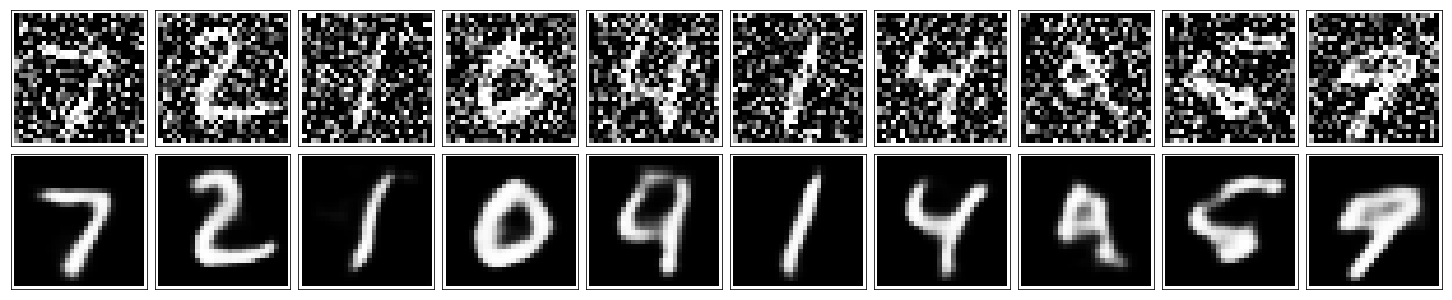

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)